# Hybrid Book Recommendation System: A Tale of Two Engines

**Produced by: A Senior Machine Learning Engineer**

Welcome! In this notebook, we'll build a powerful book recommendation system from scratch. Our goal is to combine two different but powerful techniques to create a 'hybrid' engine. This project is designed to be a masterclass in recommendation systems, explained with the simplicity for a business stakeholder but with the technical depth for a fellow engineer.

## The Two Engines

Imagine you have two expert friends helping you pick a book:

1.  **The Content Connoisseur (Content-Based Filtering):** This friend has read every book's summary. If you tell them you loved a book about space-faring detectives, they'll find other books with similar themes and descriptions. They judge a book by its cover (and its content!).

2.  **The People Person (Collaborative Filtering):** This friend knows everyone's reading habits. If you and your friend Alice both love *Dune*, this expert will look at what else Alice loved (that you haven't read yet) and recommend it to you. They believe in the wisdom of the crowd.

Our **Hybrid System** will listen to both friends to give you the best possible recommendations.

## Step 0: Setting Up Our Workshop (Imports & Installs)

First, let's gather all the tools we'll need for our project. If you're running this for the first time, you might need to install some of these libraries.

In [1]:
# %pip install numpy pandas scikit-learn sentence-transformers matplotlib scikit-learn-extra

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# For reproducibility
np.random.seed(42)

c:\Apps\miniconda3\envs\dl-ops\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Creating Our Fictional Universe of Books & Readers

Every recommendation system needs data. Since we don't have a real bookstore's data, we'll create our own! We'll generate 1000 unique books and 100 avid readers. This process is crucial as it mimics the kind of data we'd see in the real world.

In [2]:
# --- 1.1 Create the Books Dataset ---
num_books = 1000
genres = ['Sci-Fi', 'Fantasy', 'Mystery', 'Thriller', 'Romance', 'Historical Fiction', 'Biography']
adjectives = ['Cosmic', 'Forgotten', 'Silent', 'Whispering', 'Eternal', 'Broken', 'Crystal']
nouns = ['Odyssey', 'Kingdom', 'Witness', 'Shadow', 'Love', 'Empire', 'Truth']

books_data = {
    'book_id': range(num_books),
    'title': [f"{np.random.choice(adjectives)} {np.random.choice(nouns)} Vol. {i % 10}" for i in range(num_books)],
    'genre': [np.random.choice(genres) for _ in range(num_books)],
}

# Let's create some creative descriptions
descriptions = []
for i in range(num_books):
    genre = books_data['genre'][i]
    title = books_data['title'][i]
    if genre == 'Sci-Fi':
        desc = f"A journey through a {adjectives[i%len(adjectives)].lower()} galaxy, where the crew of Starship Enterprise must uncover the {nouns[i%len(nouns)].lower()} before it's too late."
    elif genre == 'Fantasy':
        desc = f"In a land of myth and magic, a young hero must reclaim the {nouns[i%len(nouns)].lower()} from the clutches of a dark sorcerer. Dragons, elves, and epic battles await in the world of {title}."
    elif genre == 'Mystery':
        desc = f"Detective Harding is on the case of the {adjectives[i%len(adjectives)].lower()} {nouns[i%len(nouns)].lower()}. A classic whodunit with a shocking twist that will keep you guessing."
    elif genre == 'Thriller':
        desc = f"A heart-pounding race against time. An agent has 24 hours to stop a global conspiracy tied to the {nouns[i%len(nouns)].lower()}. The stakes have never been higher."
    elif genre == 'Romance':
        desc = f"Two souls from different worlds find an {adjectives[i%len(adjectives)].lower()} connection. But can their love survive the secrets of the past? A story about passion and the {nouns[i%len(nouns)].lower()}."
    elif genre == 'Historical Fiction':
        desc = f"Set against the backdrop of the Roman {nouns[i%len(nouns)].lower()}, this novel tells the story of a family torn apart by war and ambition. A vivid and epic tale."
    else: # Biography
        desc = f"The inspiring true story of a person who discovered the {nouns[i%len(nouns)].lower()} and changed the world. An intimate look at a life of struggle and triumph."
    descriptions.append(desc)

books_data['description'] = descriptions
books_df = pd.DataFrame(books_data)

# --- 1.2 Create Users and Ratings ---
num_users = 100
users_data = {'user_id': range(num_users)}
users_df = pd.DataFrame(users_data)

# Create a sparse ratings dataframe (each user rates ~30 books)
ratings = []
for user_id in range(num_users):
    num_ratings = np.random.randint(20, 50)
    books_rated = np.random.choice(books_df['book_id'], num_ratings, replace=False)
    for book_id in books_rated:
        # Ratings are from 1 to 5
        rating = np.random.randint(1, 6)
        ratings.append({'user_id': user_id, 'book_id': book_id, 'rating': rating})

ratings_df = pd.DataFrame(ratings)

print("--- Books Dataset ---")
print(books_df.head())
print(f"\nShape: {books_df.shape}")

print("\n--- Ratings Dataset ---")
print(ratings_df.head())
print(f"\nShape: {ratings_df.shape}")

--- Books Dataset ---
   book_id                     title               genre  \
0        0     Crystal Shadow Vol. 0             Romance   
1        1      Eternal Truth Vol. 1  Historical Fiction   
2        2        Silent Love Vol. 2             Romance   
3        3      Eternal Truth Vol. 3             Mystery   
4        4  Forgotten Witness Vol. 4             Fantasy   

                                         description  
0  Two souls from different worlds find an cosmic...  
1  Set against the backdrop of the Roman kingdom,...  
2  Two souls from different worlds find an silent...  
3  Detective Harding is on the case of the whispe...  
4  In a land of myth and magic, a young hero must...  

Shape: (1000, 4)

--- Ratings Dataset ---
   user_id  book_id  rating
0        0      477       1
1        0      779       5
2        0      893       2
3        0      985       4
4        0      796       4

Shape: (3579, 3)


## Part 2: The Content Connoisseur (Content-Based Filtering)

Our first expert focuses only on the books themselves. We'll teach our machine to understand the *meaning* behind the book descriptions and group similar books together.

### Step 2.1: Teaching the Machine to Read (Creating Embeddings)

**To a Business Stakeholder:** Computers don't understand words, they understand numbers. We're using a state-of-the-art AI model (from Google's research) to convert each book's description into a list of numbers, called an "embedding." This embedding captures the description's meaning. Books with similar meanings will have similar lists of numbers.

**To a Technical Stakeholder:** We'll use a pre-trained Sentence-BERT model (`all-MiniLM-L6-v2`) to generate 384-dimensional embeddings for each book's description. This is a highly efficient model that produces excellent semantic representations for sentences, perfect for our task.

In [3]:
# Load a pre-trained model
# This model is great for finding semantic similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for all book descriptions
book_embeddings = model.encode(books_df['description'].tolist(), show_progress_bar=True)

print("Shape of our book embeddings matrix:", book_embeddings.shape)
print("Each book is now represented by a vector of 384 numbers.")

Batches: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]

Shape of our book embeddings matrix: (1000, 384)
Each book is now represented by a vector of 384 numbers.


### Step 2.2: Finding "Book Tribes" (Clustering)

**To a Business Stakeholder:** Now that all our books are represented by numbers, we can group them. Imagine plotting all 1,000 books on a giant map where books with similar descriptions are placed close together. We'll then draw circles around the natural clusters that form. We'll call these our "book tribes" or genres.

**To a Technical Stakeholder:** We will apply the K-Means clustering algorithm to our book embeddings. The goal is to partition the 1000 books into *k* clusters where each book belongs to the cluster with the nearest mean. We'll choose *k*=10 to create a decent number of thematic groups.

In [4]:
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(book_embeddings)

# Assign each book to its cluster
books_df['content_cluster'] = kmeans.labels_

print("Books with their new 'Content Cluster':")
print(books_df[['book_id', 'title', 'genre', 'content_cluster']].head())

c:\Apps\miniconda3\envs\dl-ops\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Books with their new 'Content Cluster':
   book_id                     title               genre  content_cluster
0        0     Crystal Shadow Vol. 0             Romance                3
1        1      Eternal Truth Vol. 1  Historical Fiction                2
2        2        Silent Love Vol. 2             Romance                3
3        3      Eternal Truth Vol. 3             Mystery                4
4        4  Forgotten Witness Vol. 4             Fantasy                5


#### Visualizing the Book Tribes

A picture is worth a thousand words. Let's visualize our book clusters. Since we can't see in 384 dimensions, we'll use a technique called PCA to squash those dimensions down to 2, just for the plot. This helps us see how well our clustering worked.

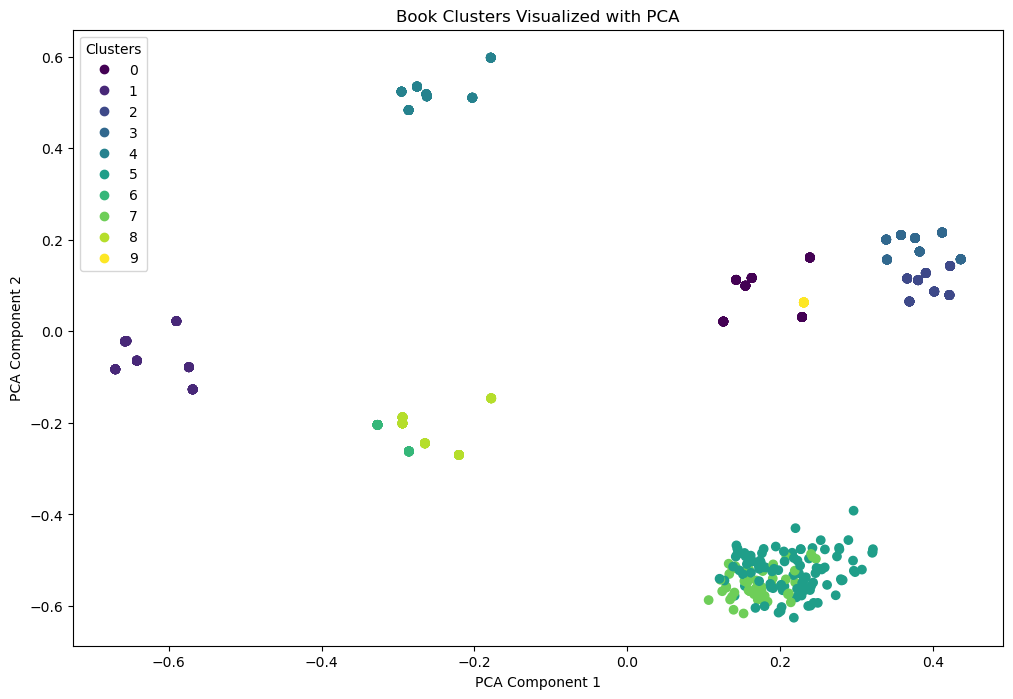

In [5]:
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(book_embeddings)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=books_df['content_cluster'], cmap='viridis')
plt.title('Book Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(num_clusters), title="Clusters")
plt.show()

### Step 2.3: Making Content-Based Recommendations

The logic is simple: if a user liked a book, they'll probably like other books from the same "tribe" or cluster.

**How it works:**
1.  Find the last book a user rated highly (e.g., 4 or 5 stars).
2.  Identify the cluster that book belongs to.
3.  Recommend other books from that same cluster which the user hasn't read yet.

In [6]:
def recommend_content_based(user_id, ratings_df, books_df, top_n=5):
    """Recommends books based on content clustering."""
    # Get books the user has already rated
    user_rated_books = ratings_df[ratings_df['user_id'] == user_id]
    
    # Find the user's favorite book (highest rating)
    if user_rated_books.empty:
        return f"User {user_id} has not rated any books yet."
    
    favorite_book_id = user_rated_books.sort_values('rating', ascending=False).iloc[0]['book_id']
    
    # Get the cluster of the favorite book
    favorite_book_cluster = books_df.loc[books_df['book_id'] == favorite_book_id, 'content_cluster'].values[0]
    
    # Find all books in the same cluster
    recommendations = books_df[books_df['content_cluster'] == favorite_book_cluster]
    
    # Filter out books the user has already read
    read_book_ids = user_rated_books['book_id'].tolist()
    recommendations = recommendations[~recommendations['book_id'].isin(read_book_ids)]
    
    return recommendations.head(top_n)

# --- Let's test it for User 5 ---
test_user_id = 5
print(f"Content-Based Recommendations for User {test_user_id}:")
content_recs = recommend_content_based(test_user_id, ratings_df, books_df)
print(content_recs[['book_id', 'title', 'genre']])

Content-Based Recommendations for User 5:
    book_id                      title     genre
13       13  Whispering Kingdom Vol. 3  Thriller
24       24      Cosmic Witness Vol. 4  Thriller
28       28    Forgotten Shadow Vol. 8  Thriller
46       46  Whispering Kingdom Vol. 6  Thriller
51       51  Whispering Odyssey Vol. 1  Thriller


## Part 3: The People Person (Collaborative Filtering)

Our second expert ignores the book's content and focuses entirely on user behavior. The core idea is: "Users who agreed in the past will likely agree in the future."

### Step 3.1: The Big Picture (User-Item Matrix)

**To a Business Stakeholder:** We'll create a giant spreadsheet. The rows are our 100 users, and the columns are our 1000 books. In each cell, we'll put the rating a user gave a book. Most of this spreadsheet will be empty, because no one has read all 1000 books. Our job is to intelligently fill in the blanks.

**To a Technical Stakeholder:** We'll pivot our `ratings_df` to create a user-item matrix. The missing values (NaNs) represent unrated books, which we'll fill with 0 for computational purposes.

In [7]:
user_item_matrix = ratings_df.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

print("--- User-Item Matrix ---")
print(user_item_matrix.head())
print(f"\nShape: {user_item_matrix.shape}")

--- User-Item Matrix ---
book_id  0    1    2    3    4    5    6    7    8    9    ...  990  991  992  \
user_id                                                    ...                  
0        0.0  0.0  0.0  0.0  3.0  0.0  2.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0  ...  0.0  0.0  0.0   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  3.0   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

book_id  993  994  995  996  997  998  999  
user_id                                     
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2        5.0  0.0  0.0  0.0  0.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  0.0  3.0  0.0  
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 974 columns]

Shape: (100, 974)


### Step 3.2: Finding Hidden Tastes (Matrix Factorization with SVD)

**To a Business Stakeholder:** This is the magic trick. We're going to break down our giant, sparse spreadsheet into two smaller, much denser ones:
1.  A "User-Taste" spreadsheet (e.g., how much each user likes sci-fi, or mystery, or epic stories).
2.  A "Book-Ingredient" spreadsheet (e.g., how much each book *is* sci-fi, or a mystery, or an epic story).

The computer learns these "tastes" and "ingredients" automatically just by looking at the ratings we have. By multiplying these two small spreadsheets back together, we can predict what a user would rate a book they've never read.

**To a Technical Stakeholder:** We'll use Singular Value Decomposition (SVD), a powerful matrix factorization technique. Specifically, `TruncatedSVD` is perfect for sparse matrices like ours. It decomposes the user-item matrix `A` into three matrices: `U`, `Σ`, and `V^T`. We'll use it to create a lower-dimensional representation (50 latent features) that captures the main patterns of user-book interactions.

In [8]:
n_latent_factors = 50
svd = TruncatedSVD(n_components=n_latent_factors, random_state=42)

# Decompose the original matrix
user_factors = svd.fit_transform(user_item_matrix)

# Reconstruct the matrix to get predicted ratings
predicted_ratings = np.dot(user_factors, svd.components_)

# Wrap it in a DataFrame for easy use
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

print("Shape of our User-Factor matrix (User-Tastes):", user_factors.shape)
print("Shape of our SVD components (Book-Ingredients):", svd.components_.shape)
print("\n--- Predicted Ratings Matrix (with filled-in blanks) ---")
print(predicted_ratings_df.head())

Shape of our User-Factor matrix (User-Tastes): (100, 50)
Shape of our SVD components (Book-Ingredients): (50, 974)

--- Predicted Ratings Matrix (with filled-in blanks) ---
book_id       0         1         2         3         4         5         6    \
user_id                                                                         
0       -0.061032  0.021063  0.370357 -0.191376  2.184886  0.103884  1.336123   
1       -0.007620 -0.012044  0.038011  0.025959  0.248875  0.249782 -0.031467   
2        0.079378  0.044435 -0.152793 -0.000092  0.174299 -0.183128  0.081969   
3       -0.006386 -0.027556  0.251375 -0.212562 -0.096524  0.571563  0.017052   
4       -0.008824 -0.020525 -0.226703 -0.149345  0.300809 -0.160677 -0.164368   

book_id       7         8         9    ...       990       991       992  \
user_id                                ...                                 
0        0.104996  0.028958  0.195490  ...  0.183896  0.129037  0.064604   
1        0.171121  0.057041 -0.

### Step 3.3: Making Collaborative Filtering Recommendations

Now that we've predicted every user's rating for every book, making recommendations is easy.

**How it works:**
1.  For a given user, look up their row in our `predicted_ratings_df`.
2.  Sort the books by their predicted rating in descending order.
3.  Filter out books the user has already read.
4.  Return the top N books.

In [9]:
def recommend_collaborative(user_id, user_item_matrix, predicted_ratings_df, books_df, top_n=5):
    """Recommends books based on collaborative filtering (SVD)."""
    # Get predicted ratings for the user
    user_predictions = predicted_ratings_df.loc[user_id].sort_values(ascending=False)
    
    # Get books the user has already read
    user_rated_books = user_item_matrix.loc[user_id]
    read_book_ids = user_rated_books[user_rated_books > 0].index
    
    # Filter out read books and recommend the top N
    recommendations = user_predictions[~user_predictions.index.isin(read_book_ids)]
    top_book_ids = recommendations.head(top_n).index
    
    return books_df[books_df['book_id'].isin(top_book_ids)]

# --- Let's test it for the same User 5 ---
print(f"Collaborative Filtering Recommendations for User {test_user_id}:")
collab_recs = recommend_collaborative(test_user_id, user_item_matrix, predicted_ratings_df, books_df)
print(collab_recs[['book_id', 'title', 'genre']])

Collaborative Filtering Recommendations for User 5:
     book_id                  title               genre
133      133  Cosmic Witness Vol. 3             Romance
214      214    Crystal Love Vol. 4             Romance
263      263  Silent Odyssey Vol. 3           Biography
704      704  Broken Witness Vol. 4  Historical Fiction
722      722  Crystal Shadow Vol. 2  Historical Fiction


## Part 4: The Hybrid System - The Best of Both Worlds

Why choose one expert when you can have both? Our hybrid system will combine the scores from the Content Connoisseur and the People Person to create a final, superior recommendation list.

### Step 4.1: Combining the Scores (Rank-based Hybrid)

**To a Business Stakeholder:** We'll ask both our experts for their top 10 recommendations. Then, we'll give points to each book based on its rank. A #1 recommendation gets 10 points, #2 gets 9, and so on. We add up the points for each book from both lists and the books with the highest total score are our final recommendations. This ensures we value the opinions of both experts.

**To a Technical Stakeholder:** We'll implement a rank-based hybrid model. We'll generate two separate recommendation lists: one from our content-based model (based on cluster similarity) and one from our collaborative filtering model (SVD predicted ratings). We'll then assign a score to each recommended item based on its position in the list (e.g., `score = 1 / (rank + 1)`). Finally, we'll combine these scores for items that appear on both lists and re-rank to produce the final hybrid list.

In [10]:
def generate_hybrid_recommendations(user_id, ratings_df, books_df, user_item_matrix, predicted_ratings_df, top_n=5):
    # --- Get Content-Based Recommendations (we need a score here) ---
    user_rated_books = ratings_df[ratings_df['user_id'] == user_id]
    if user_rated_books.empty:
        return pd.DataFrame() # No recommendations if user has no ratings
    
    favorite_book_id = user_rated_books.sort_values('rating', ascending=False).iloc[0]['book_id']
    favorite_book_embedding = book_embeddings[favorite_book_id]
    
    # Calculate cosine similarity between favorite book and all other books
    content_scores = cosine_similarity([favorite_book_embedding], book_embeddings)[0]
    content_scores_df = pd.DataFrame({'book_id': books_df['book_id'], 'content_score': content_scores})
    
    # --- Get Collaborative Filtering Recommendations ---
    collab_scores = predicted_ratings_df.loc[user_id]
    collab_scores_df = pd.DataFrame({'book_id': collab_scores.index, 'collab_score': collab_scores.values})
    
    # --- Combine the scores ---
    # Merge the two score dataframes
    hybrid_scores_df = pd.merge(content_scores_df, collab_scores_df, on='book_id')
    
    # Normalize scores to be between 0 and 1 so they can be combined
    scaler = MinMaxScaler()
    hybrid_scores_df[['content_score', 'collab_score']] = scaler.fit_transform(hybrid_scores_df[['content_score', 'collab_score']])
    
    # Give equal weight to both models
    hybrid_scores_df['final_score'] = 0.5 * hybrid_scores_df['content_score'] + 0.5 * hybrid_scores_df['collab_score']
    
    # --- Filter and Rank ---
    # Filter out books the user has already read
    read_book_ids = ratings_df[ratings_df['user_id'] == user_id]['book_id'].tolist()
    hybrid_scores_df = hybrid_scores_df[~hybrid_scores_df['book_id'].isin(read_book_ids)]
    
    # Sort by final score
    final_recs = hybrid_scores_df.sort_values('final_score', ascending=False).head(top_n)
    
    return pd.merge(final_recs, books_df, on='book_id')

# --- Let's test the final system for User 5 ---
print(f"Hybrid Recommendations for User {test_user_id}:")
hybrid_recs = generate_hybrid_recommendations(test_user_id, ratings_df, books_df, user_item_matrix, predicted_ratings_df)
print(hybrid_recs[['book_id', 'title', 'genre', 'final_score']])

Hybrid Recommendations for User 5:
   book_id                   title     genre  final_score
0      998     Eternal Love Vol. 8  Thriller     0.736135
1      135   Eternal Shadow Vol. 5  Thriller     0.714310
2      438   Eternal Empire Vol. 8  Thriller     0.712704
3      293    Cosmic Empire Vol. 3  Thriller     0.711616
4      900  Forgotten Truth Vol. 0  Thriller     0.692499


## Part 5: From Prototype to Production - Designing a Real-Time System

This notebook is a fantastic prototype. But how do we make this a real, live system that serves millions of users? Here’s a high-level architectural design.

**Stakeholder Summary:** To make this system fast and scalable, we need to separate the slow, heavy-duty calculations (done offline) from the fast, real-time recommendations (done instantly when a user visits our app).

--- 

### Architectural Blueprint

We'll split our system into two main parts: **Offline Batch Processing** and **Online Real-Time Serving**.

#### 1. Offline Batch Processing (The Nightly Librarian)

This part runs periodically (e.g., every night) to do the heavy lifting. It's like a librarian organizing the entire library before the doors open.

*   **Data Ingestion:** A daily job (e.g., using Apache Airflow) pulls new user ratings, new books, and user activity logs from the production database and event streams (like Kafka).
*   **Content Model Training (`Content-Based`):**
    *   For any new or updated books, we generate their sentence embeddings using our `SentenceTransformer` model. This can be a resource-intensive task, so we do it offline.
    *   We store these embeddings in a fast-access database, like a **Vector Database** (e.g., Pinecone, Milvus, or FAISS index in S3). This allows for incredibly fast "find similar vectors" queries.
*   **Collaborative Model Training (`Collaborative Filtering`):**
    *   We rebuild the full User-Item Matrix with all the latest ratings.
    *   We re-run our SVD (or a more advanced model like ALS from Spark MLlib for distributed computing) on this new matrix.
    *   The output isn't the full predicted ratings matrix (that's too big!). Instead, we pre-compute the **Top N recommendations for every single user**.
*   **Storing Pre-computed Results:**
    *   The Top N collaborative filtering recommendations for each user are stored in a fast key-value store like **Redis** or **DynamoDB**. The key is the `user_id`, and the value is a list of `book_ids` (`user:123 -> [b45, b89, b12, ...]`).



#### 2. Online Real-Time Serving (The Instant Helper)

This is what happens the moment a user opens the app or website. It needs to be lightning fast.

*   **API Request:** The user's device sends a request to our Recommendation API, e.g., `GET /api/recommendations/user/123`.
*   **Fetching Candidates:**
    1.  **Collaborative Candidates:** The API instantly queries Redis/DynamoDB for `user:123` to get the pre-computed list of 50-100 book recommendations. This is extremely fast (sub-millisecond latency).
    2.  **Content-Based Candidates:** The API identifies the user's most recent interaction (e.g., the book they just clicked on). It fetches the embedding for this book and queries the Vector Database to find the 50-100 most similar books. This is also very fast.
*   **Real-Time Hybrid Ranking (Re-ranking):**
    *   Now we have two lists of candidate books. A lightweight ranking model (it could be as simple as our weighted score, or a small machine learning model) combines these two lists.
    *   This re-ranker can also incorporate **real-time context**: Is the user on a mobile device? Is it morning or evening? Are they a new user? This allows for dynamic, personalized adjustments.
    *   It filters out books the user has already seen/bought (by checking another Redis set).
*   **Serving the Response:** The final, ranked list of Top 10 book IDs is sent back to the user's device. The device then fetches the book details (title, cover image) from a separate service to display them.



### Why this design is SOTA (State-of-the-Art):

*   **Scalability:** By separating batch and real-time, we can handle millions of users and items. The heavy computation doesn't block user requests.
*   **Speed:** User-facing requests only involve fast lookups from Redis and a vector DB, ensuring a snappy user experience.
*   **Flexibility:** The re-ranking step allows us to be agile. We can easily tweak the hybrid strategy, add business rules (e.g., "boost newly published books"), or experiment with different models without retraining everything.
*   **Handles the "Cold Start" Problem:** For a brand new user (no ratings), we can't use collaborative filtering. But we can still use the content-based approach! If they click on one book, we can instantly recommend similar ones. For a brand new book, it won't have ratings, but our content-based model can immediately add it to a cluster and start recommending it to the right audience.